In [4]:
%matplotlib inline
import sys
import random
import xarray as xr
import numpy as np
import os
import yaml
import math
from datetime import datetime, timedelta
from parcels import FieldSet, Field, VectorField, ParticleSet, JITParticle, ParcelsRandom, Variable, Kernel, AdvectionRK4

import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib import colors
from cartopy import crs, feature
import zarr 
import glob
# For polygons
from shapely.geometry import Polygon, Point

sys.path.append('/ocean/vvalenzuela/MOAD/Ocean_Parcels')

from OP_functions import *
import cmocean
cmap = cmocean.cm.deep

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [5]:
path = {'NEMO': '/results2/SalishSea/nowcast-green.202111/',
'coords': '/ocean/vvalenzuela/MOAD/grid/coordinates_seagrid_SalishSea201702.nc',
'coordsWW3': '/ocean/vvalenzuela/MOAD/grid2/WW3_grid.nc',
'mask': '/ocean/vvalenzuela/MOAD/grid2/mesh_mask202108_TDV.nc',
'bat': '/ocean/vvalenzuela/MOAD/grid/bathymetry_202108.nc',
'out': '/home/vvalenzuela/MOAD/Ocean_Parcels/results/Test_runs',
'home': '/home/vvalenzuela/MOAD/Ocean_Parcels',
'anim': '/home/vvalenzuela/MOAD/Ocean_Parcels/results/PBDE_runs/animations'}
#
coords = xr.open_dataset(path['coords'], decode_times=False)
mask = xr.open_dataset(path['mask'])
bathy = xr.open_dataset(path['bat'])

**Simulation Checking**

Runs:
- 7 days, 2 days of hourly release, 5 particles per hour (done)
- 30 days, 7 days of hourly release, 5 particles per hour (running)

In [6]:
file_name = '/home/vvalenzuela/MOAD/Ocean_Parcels/results/Test_runs/Test_hourly_V2/PBDEs_run_for_11_days_5_hourly_particles_20220101_1n_20220112_1n.zarr'
#file_name = '/home/vvalenzuela/MOAD/Ocean_Parcels/results/Test_runs/Test_hourly_V2/PBDEs_run_for_44_days_5_hourly_particles_20220101_1n_20220214_1n.zarr'
data = xr.open_zarr(file_name, decode_times=True)
depth = data.z/data.fact

In [7]:
limit_begin_end = int(timedelta(days=2).total_seconds()/(60*60))
print(limit_begin_end)

48


In [8]:
data_analysis = data.isel(obs=slice(limit_begin_end, -limit_begin_end))
tt = []
for i in range(0,len(data_analysis.obs)):
    tt.append(np.min(data_analysis.time[0,0].values).astype('datetime64[s]').tolist() + i*timedelta(hours=1))
times = np.tile(tt, (len(data_analysis.trajectory), 1))
#
data_analysis['time'].values = times

In [9]:
def particles_concentration_map(lons, lats, mask=mask, num_lon=30, num_lat=40):
    # Define lon and lat lenght 
    longitudes = np.linspace(mask['nav_lon'].min(), mask['nav_lon'].max(), num_lon + 1)
    latitudes = np.linspace(mask['nav_lat'].min(), mask['nav_lat'].max(), num_lat + 1)
    #
    # Particle positions into bins
    lon_indices = np.digitize(lons, longitudes) - 1 
    lat_indices = np.digitize(lats, latitudes) - 1
    #
    amount = np.zeros((num_lon, num_lat))
    #
    valid_mask = (lon_indices >= 0) & (lon_indices < num_lon) & (lat_indices >= 0) & (lat_indices < num_lat)
    lon_indices, lat_indices = lon_indices[valid_mask], lat_indices[valid_mask]
    # Count particles 
    indices = np.ravel_multi_index((lon_indices, lat_indices), dims=(num_lon, num_lat))
    counts = np.bincount(indices, minlength=num_lon * num_lat).reshape((num_lon, num_lat))
    #
    amount[:counts.shape[0], :counts.shape[1]] = counts
    #
    return pd.DataFrame(amount)

In [10]:
concentration_B = particles_concentration_map(lons=data.where(data['status'] == 4)['lon'], lats=data.where(data['status'] == 4)['lat'])
concentration_MP = particles_concentration_map(lons=data.where(data['status'] == 3)['lon'], lats=data.where(data['status'] == 3)['lat'])
concentration_C = particles_concentration_map(lons=data.where(data['status'] == 2)['lon'], lats=data.where(data['status'] == 2)['lat'])
concentration_SP = particles_concentration_map(lons=data.where(data['status'] == 1)['lon'], lats=data.where(data['status'] == 1)['lat'])
total_concentration = particles_concentration_map(lons=data['lon'], lats=data['lat'])

In [11]:
clat = [49.195045]
clon = [-123.301956]
num_lon = 30
num_lat = 40
longitudes = np.linspace(mask['nav_lon'].min(), mask['nav_lon'].max(), num_lon+1)
latitudes = np.linspace(mask['nav_lat'].min(), mask['nav_lat'].max(), num_lat+1)

/tmp/ipykernel_2759803/3649544219.py:10: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  ax.pcolormesh(mask['nav_lon'], mask['nav_lat'], mask['tmask'][0][0], cmap = cmap)
/tmp/ipykernel_2759803/3649544219.py:26: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  ax[0,0].pcolormesh(mask['nav_lon'], mask['nav_lat'], mask['tmask'][0][0], cmap = cmap)
/tmp/ipykernel_2759803/3649544219.py:35: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, ple

Text(0.5, 0, 'Longitude')

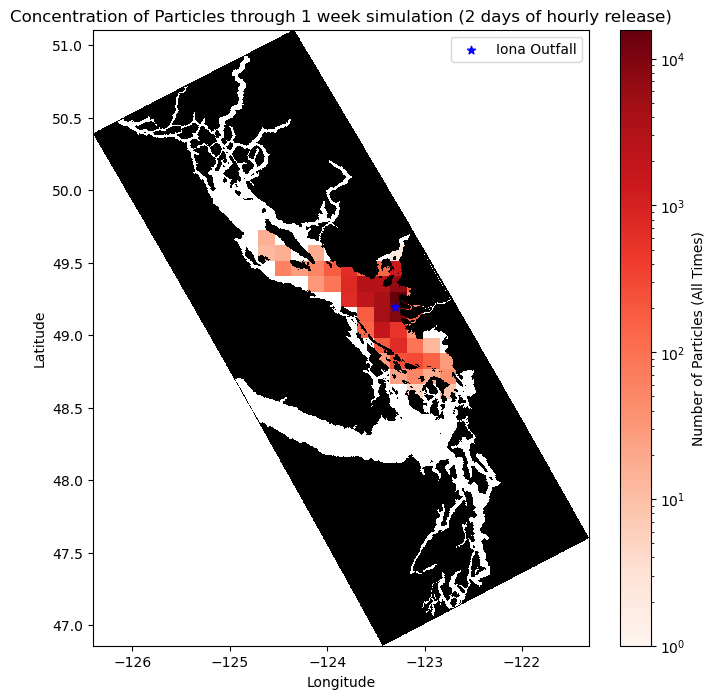

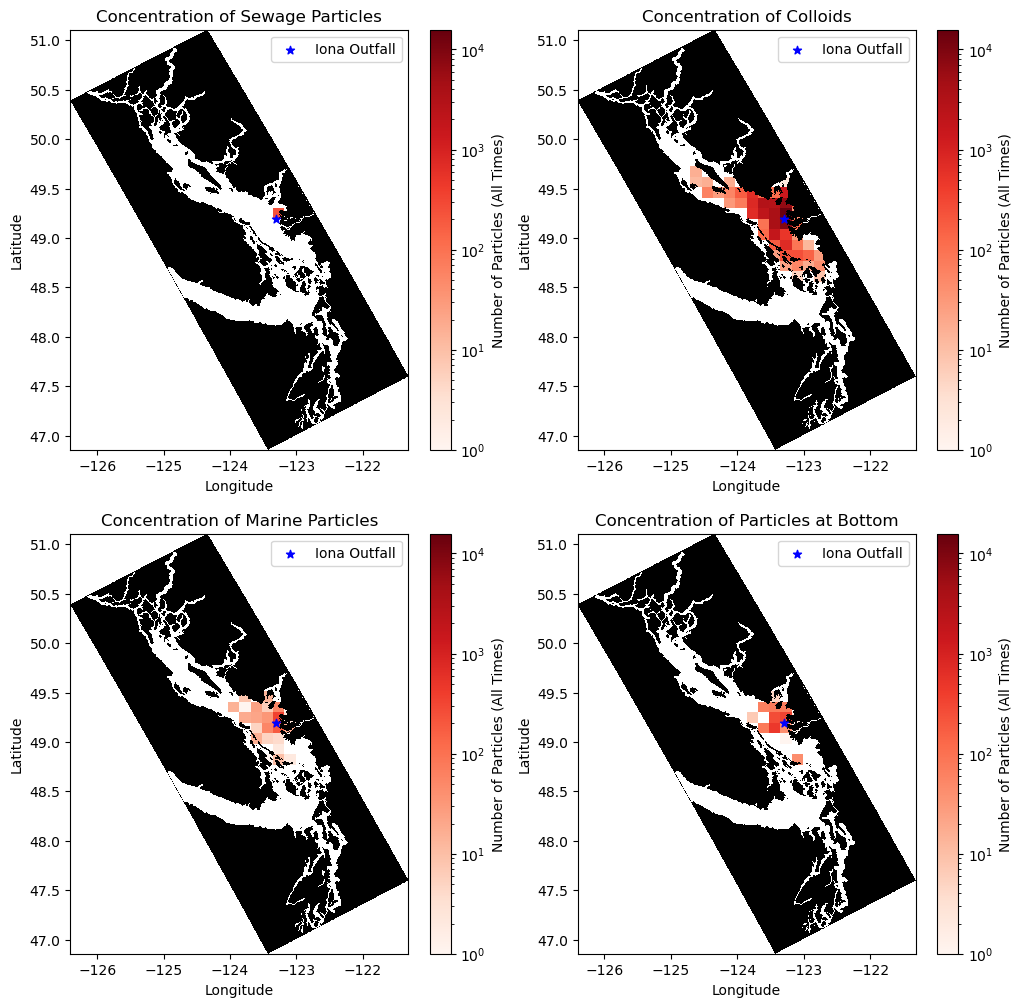

In [12]:
from matplotlib.colors import LogNorm
from matplotlib.colors import ListedColormap
#
colors = [(0, 0, 0, 1),  # Black for land (1)
          (0, 0, 0, 0)]  # Transparent for water (0)
cmap = ListedColormap(colors)
#
fig, ax = plt.subplots(figsize=(8,8))
c = ax.pcolormesh(longitudes, latitudes, total_concentration.T, cmap='Reds', norm=LogNorm(vmin=total_concentration.min().min()+10e-1, vmax=total_concentration.max().max()))
ax.pcolormesh(mask['nav_lon'], mask['nav_lat'], mask['tmask'][0][0], cmap = cmap)
#ax.set_xlim(0,tmask.x[-1])
#ax.set_ylim(0, tmask.y[-1])
#
ax.scatter(clon,clat, c = 'b', marker = '*', label = 'Iona Outfall')
#
fig.colorbar(c, ax=ax, label="Number of Particles (All Times)")
ax.legend()
#
ax.set_title('Concentration of Particles through 1 week simulation (2 days of hourly release)')
ax.set_ylabel('Latitude')
ax.set_xlabel('Longitude')
#
fig, ax = plt.subplots(2,2,figsize=(12,12))
#
sewage = ax[0,0].pcolormesh(longitudes, latitudes, concentration_SP.T, cmap='Reds', norm=LogNorm(vmin=concentration_SP.min().min()+1, vmax=total_concentration.max().max()))
ax[0,0].pcolormesh(mask['nav_lon'], mask['nav_lat'], mask['tmask'][0][0], cmap = cmap)
ax[0,0].scatter(clon,clat, c = 'b', marker = '*', label = 'Iona Outfall')
fig.colorbar(sewage, ax=ax[0,0], label="Number of Particles (All Times)")
ax[0,0].legend()
ax[0,0].set_title('Concentration of Sewage Particles')
ax[0,0].set_ylabel('Latitude')
ax[0,0].set_xlabel('Longitude')
#
colloids = ax[0,1].pcolormesh(longitudes, latitudes, concentration_C.T, cmap='Reds', norm=LogNorm(vmin=concentration_C.min().min()+1, vmax=total_concentration.max().max()))
ax[0,1].pcolormesh(mask['nav_lon'], mask['nav_lat'], mask['tmask'][0][0], cmap = cmap)
ax[0,1].scatter(clon,clat, c = 'b', marker = '*', label = 'Iona Outfall')
fig.colorbar(sewage, ax=ax[0,1], label="Number of Particles (All Times)")
ax[0,1].legend()
ax[0,1].set_title('Concentration of Colloids')
ax[0,1].set_ylabel('Latitude')
ax[0,1].set_xlabel('Longitude')
#
marine = ax[1,0].pcolormesh(longitudes, latitudes, concentration_MP.T, cmap='Reds', norm=LogNorm(vmin=concentration_MP.min().min()+1, vmax=total_concentration.max().max()))
ax[1,0].pcolormesh(mask['nav_lon'], mask['nav_lat'], mask['tmask'][0][0], cmap = cmap)
ax[1,0].scatter(clon,clat, c = 'b', marker = '*', label = 'Iona Outfall')
fig.colorbar(sewage, ax=ax[1,0], label="Number of Particles (All Times)")
ax[1,0].legend()
ax[1,0].set_title('Concentration of Marine Particles')
ax[1,0].set_ylabel('Latitude')
ax[1,0].set_xlabel('Longitude')
#
bottom = ax[1,1].pcolormesh(longitudes, latitudes, concentration_B.T, cmap='Reds', norm=LogNorm(vmin=concentration_B.min().min()+1, vmax=total_concentration.max().max()))
ax[1,1].pcolormesh(mask['nav_lon'], mask['nav_lat'], mask['tmask'][0][0], cmap = cmap)
ax[1,1].scatter(clon,clat, c = 'b', marker = '*', label = 'Iona Outfall')
fig.colorbar(bottom, ax=ax[1,1], label="Number of Particles (All Times)")
ax[1,1].legend()
ax[1,1].set_title('Concentration of Particles at Bottom')
ax[1,1].set_ylabel('Latitude')
ax[1,1].set_xlabel('Longitude')
